# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-fh0q_7ag
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-fh0q_7ag
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


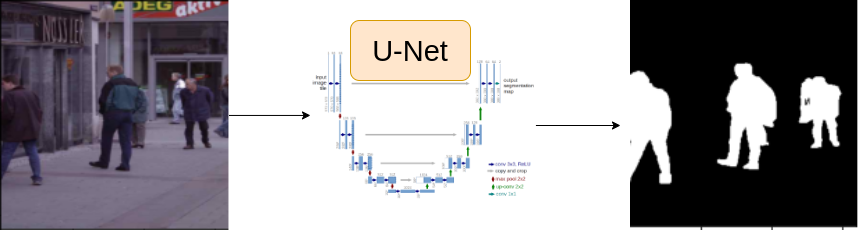

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
csv_file='/content/Human-Segmentation-Dataset-master/train.csv'
data_dir='/content/'

device='cuda'
epochs=25
LR=0.003
img_size=320
batch_size=16


In [ ]:
encoder='timm-efficientnet-b0'
weights='imagenet'

In [ ]:
df=pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[4]
image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path)
mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)


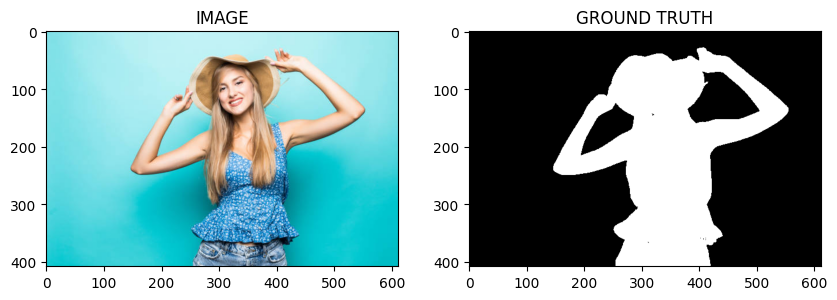

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df=train_test_split(df , test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_aug():
  return A.Compose([
      A.Resize(img_size,img_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],is_check_shapes=False)

def get_valid_aug():
  return A.Compose([
      A.Resize(img_size,img_size),
  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegDataset(Dataset):

  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]

    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)#(h,w,c)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data= self.augmentations(image=image ,mask=mask)
      image=data['image']
      mask=data['mask']

    #(h,w,c)->(c,h,w)
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask



In [ ]:
trainSet=SegDataset(train_df,get_train_aug())
ValidSet=SegDataset(valid_df,get_valid_aug())

In [ ]:
print(f"Size of Trainset : {len(trainSet)}")
print(f"Size of Validset : {len(ValidSet)}")

Size of Trainset : 232
Size of Validset : 58


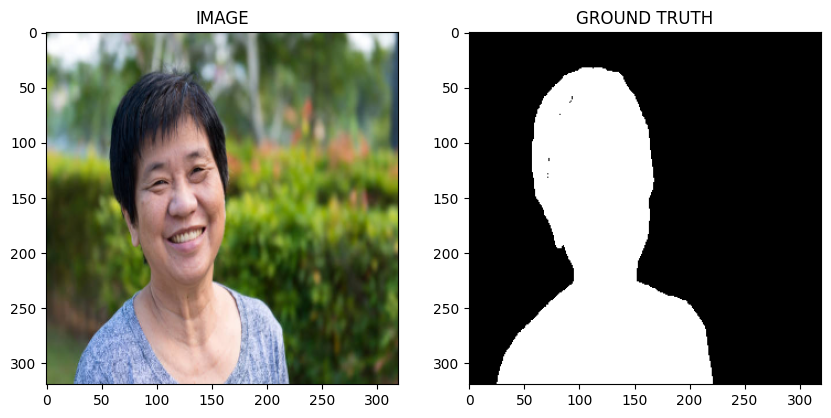

In [ ]:
idx=3
image,mask =trainSet[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainSet,batch_size=batch_size,shuffle=True)
validloader=DataLoader(ValidSet,batch_size=batch_size)

In [ ]:
print(f"total no of batches in trainloader : {len(trainloader)} ")
print(f"total no of batches in validloader : {len(validloader)} ")

total no of batches in trainloader : 15 
total no of batches in validloader : 4 


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from  segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegModel(nn.Module):

  def __init__(self):
    super(SegModel,self).__init__()

    self.arc=smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks!= None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2

    return logits

In [ ]:
model=SegModel()
model.to(device);

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader,model,optimizer):

  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):
    image=images.to(device)
    mask=masks.to(device)

    optimizer.zero_grad()
    logits,loss=model(image,mask)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)



In [ ]:
def eval_fn(data_loader,model):

  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images=images.to(device)
      masks=masks.to(device)

      logits,loss=model(images,masks)
      total_loss+=loss.item()

  return total_loss/len(data_loader)



# Task 8 : Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.03)

In [ ]:
best_valid_loss=np.Inf

for i in range(epochs):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss< best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('SAVED-Model')
    best_valid_loss=valid_loss

  print(f"Epoch:{i+1} Train_loss:{train_loss} Valid_loss : {valid_loss}")


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


SAVED-Model
Epoch:1 Train_loss:1.2788108428319296 Valid_loss : 1198140.21875


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


SAVED-Model
Epoch:2 Train_loss:1.0218589425086975 Valid_loss : 20.160828113555908


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch:3 Train_loss:0.8727885484695435 Valid_loss : 26.632397174835205


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


SAVED-Model
Epoch:4 Train_loss:0.8270344893137614 Valid_loss : 1.0392746776342392


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


SAVED-Model
Epoch:5 Train_loss:0.7643151998519897 Valid_loss : 0.8864488899707794


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Epoch:6 Train_loss:0.7515538692474365 Valid_loss : 1.1276765316724777


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


SAVED-Model
Epoch:7 Train_loss:0.7167368809382121 Valid_loss : 0.8071512281894684


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch:8 Train_loss:0.6847635388374329 Valid_loss : 1.0816819965839386


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


SAVED-Model
Epoch:9 Train_loss:0.6824203689893087 Valid_loss : 0.7933651655912399


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


SAVED-Model
Epoch:10 Train_loss:0.6550895770390829 Valid_loss : 0.7845264226198196


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Epoch:11 Train_loss:0.6538561840852102 Valid_loss : 0.8473841995000839


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch:12 Train_loss:0.6380869189898173 Valid_loss : 0.8410249352455139


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


SAVED-Model
Epoch:13 Train_loss:0.6107500235239665 Valid_loss : 0.6647559851408005


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


Epoch:14 Train_loss:0.6138508896032969 Valid_loss : 0.9942043870687485


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch:15 Train_loss:0.6396252155303955 Valid_loss : 0.6838336139917374


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


SAVED-Model
Epoch:16 Train_loss:0.5601217110951742 Valid_loss : 0.599676102399826


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch:17 Train_loss:0.5362953007221222 Valid_loss : 0.6630893647670746


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch:18 Train_loss:0.5404264231522878 Valid_loss : 0.9466114491224289


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


SAVED-Model
Epoch:19 Train_loss:0.5953555941581726 Valid_loss : 0.5826971009373665


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch:20 Train_loss:0.5251928249994914 Valid_loss : 0.6400249302387238


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


SAVED-Model
Epoch:21 Train_loss:0.549022102355957 Valid_loss : 0.505060687661171


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Epoch:22 Train_loss:0.5255303740501404 Valid_loss : 0.6408569663763046


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch:23 Train_loss:0.5046325167020161 Valid_loss : 0.6792801469564438


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch:24 Train_loss:0.48565602699915567 Valid_loss : 0.5829150229692459


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


SAVED-Model
Epoch:25 Train_loss:0.4962281107902527 Valid_loss : 0.4834645017981529


# Task 9 : Inference

In [ ]:
idx=20

model.load_state_dict(torch.load('/content/best_model.pt'))

image,mask=ValidSet[idx]

logits_mask=model(image.to(device).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

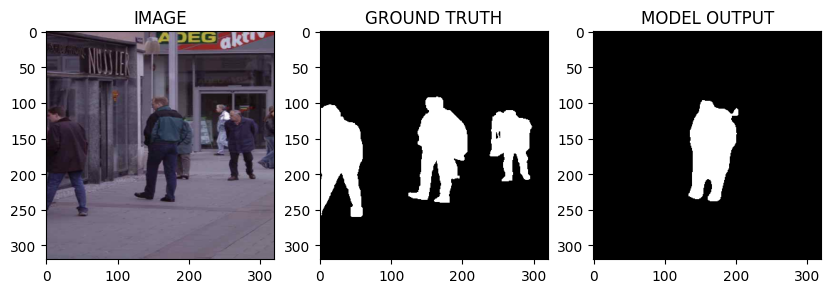

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))